# Homework 2

**The following notebook is meant to help you work through Problems 1 and 3 on Homework 2. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


In [5]:
# loading data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib.patches as mpatches
from scipy.special import expit as sigmoid
from scipy.special import softmax
from scipy.special import logsumexp

# data for Problem 1
t_obs, y_obs = np.genfromtxt("data/planet-obs.csv", delimiter = ',').T
t_obs = np.split(t_obs, 10)
y_obs = np.split(y_obs.reshape(-1, 1), 10)

# data for Problem 3
data = pd.read_csv("data/hr.csv")
mapper = {
    "Dwarf": 0,
    "Giant": 1,
    "Supergiant": 2
}
data['Type'] = data['Type'].map(mapper)

X_stars = data[['Magnitude', 'Temperature']].values
y_stars = data['Type'].values

from T2_P1_TestCases import test_p1
from T2_P3_TestCases import test_p3_softmax, test_p3_knn

# Problem 1

## Problem 1 Subpart 1

In [6]:
def basis1(t):
    return np.stack([np.ones(len(t)), t], axis=1)

def basis2(t):
    """
    Transform t into basis [1, t, t^2]

    :param t: a 1D numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 3)
    """
    return np.stack([np.ones(len(t)), t, np.square(t)], axis=1)

def basis3(t):
    """
    Transform t into basis [1, t, t^2, t^3, t^4, t^5]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 6)
    """
    return np.stack([np.ones(len(t)), t, np.square(t), np.power(t, 3), np.power(t,4), np.power(t,5)], axis=1)

In [7]:
class LogisticRegressor:
    def __init__(self, eta, runs):
        self.eta = eta
        self.runs = runs
        self.W = None

    def fit(self, x, y, w_init):
        """
        Optimize the weights W to minimize the negative log-likelihood by using gradient descent

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :param y: a 2D numpy array of output values. Shape is (n x 1)
        :param w_init: a 2D numpy array that initializes the weights. Shape is (d x 1)
        :return: None
        """
        # Keep this for the autograder
        self.W = w_init
        # print(self.W)
        #print(np.dot(self.W.transpose(),x[0]))
        for i in range(self.runs):
            #compute grad
            grad = np.zeros(len(x[0]))
            for j in range(len(y)):
                grad -=(y[j] - sigmoid(np.dot(self.W.T, x[j]))) * x[j]
            grad = (grad / len(y)).reshape(-1,1)

            # update weights
            self.W = self.W - self.eta*grad
        # print("grad is")
        # print(grad)
        # print("W is")
        # print(self.W)

    def predict(self, x):
        """
        Predict classification probability of transformed input x
        
        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :return: a 2D numpy array of predicted probabilities given current weights. Shape should be (n x 1)
        """
        #print([(1 / (1+np.power(np.e, -np.dot(self.W.transpose(), x[i])))) for i in range(len(x))])
        return np.array([sigmoid(np.dot(self.W.T, x[i])) for i in range(len(x))])

In [8]:
test_p1(LogisticRegressor, basis1, basis2, basis3)

Your test case results are, for basis 1, 2, and 3 respectively: Pass Pass Fail


## Plotting Functions for Problem 1, Subpart 2

In [9]:
# Function to visualize prediction lines
# Takes as input last_x, last_y, [list of models], basis function, title
# last_x and last_y should specifically be the dataset that the last model
# in [list of models] was trained on
def visualize_prediction_lines(last_x, last_y, models, basis, title):
    # Plot setup
    green = mpatches.Patch(color='green', label='Ground truth model')
    black = mpatches.Patch(color='black', label='Mean of learned models')
    purple = mpatches.Patch(color='purple', label='Model learned from displayed dataset')
    plt.legend(handles=[green, black, purple], loc='lower right')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Observed')
    plt.axis([0, 6, -.1, 1.1]) # Plot ranges

    # Plot dataset that last model in models (models[-1]) was trained on
    cmap = c.ListedColormap(['r', 'b'])
    plt.scatter(last_x, last_y, c=last_y, cmap=cmap, linewidths=1, edgecolors='black')

    # Plot models
    X_pred = np.linspace(0, 6, 1000)
    X_pred_transformed = basis(X_pred)

    ## Ground truth model
    plt.plot(X_pred, np.cos(1.1*X_pred + 1) * 0.4 + 0.5, 'g', linewidth=5)

    ## Individual learned logistic regressor models
    Y_hats = []
    for i in range(len(models)):
        model = models[i]
        Y_hat = model.predict(X_pred_transformed)
        Y_hats.append(Y_hat)
        if i < len(models) - 1:
            plt.plot(X_pred, Y_hat, linewidth=.3)
        else:
            plt.plot(X_pred, Y_hat, 'purple', linewidth=3)

    # Mean / expectation of learned models over all datasets
    plt.plot(X_pred, np.mean(Y_hats, axis=0), 'k', linewidth=5)

    plt.savefig(title + '.png')
    plt.show()

In [10]:
# You may find it helpful to modify this function for Problem 1, Subpart 4,
# but do not change the existing code--add your own variables
def plot_results(basis, title):
    eta = 0.001
    runs = 10000

    all_models = []
    data01 = []
    data32 = []
    for i in range(10):
        x, y = t_obs[i], y_obs[i]
        x_transformed = basis(x)
        model = LogisticRegressor(eta=eta, runs=runs)
        model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
        all_models.append(model)
        if i == 0 and title == "basis3":
            print("t = 0.1: ", model.predict(basis([0.1])))
            print("t = 3.2: ", model.predict(basis([3.2])))
        if title == "basis3":
            data01.append(model.predict(basis([0.1])))
            data32.append(model.predict(basis([3.2])))

    visualize_prediction_lines(x, y, all_models, basis, title)

    if title == "basis3":
        var01 = np.var(data01)
        var32 = np.var(data32)
        print("0.1 Var: ", var01)
        print("3.2 Var: ", var32)

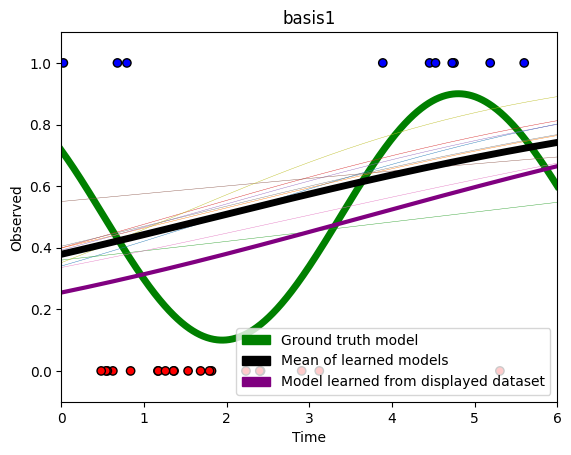

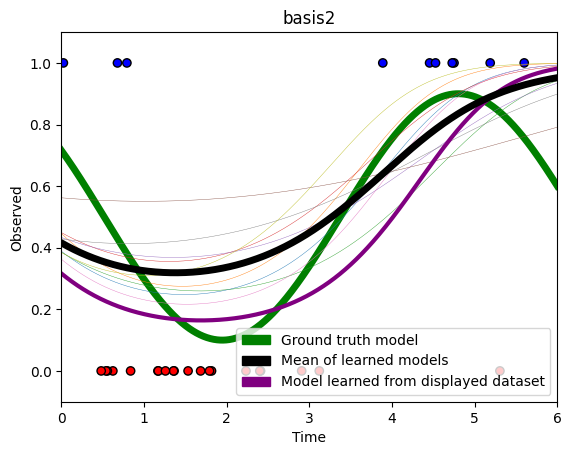

t = 0.1:  [[0.51993183]]
t = 3.2:  [[0.02485444]]


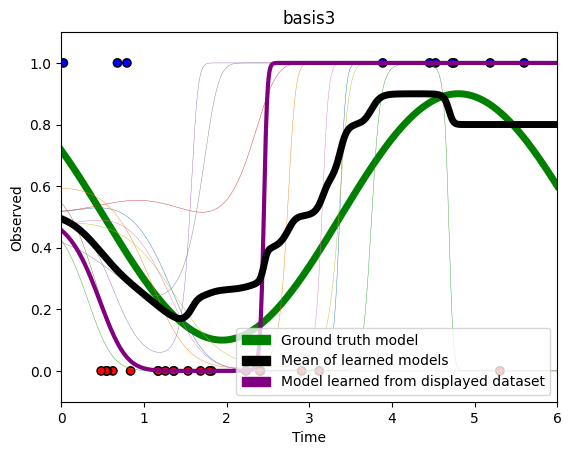

0.1 Var:  0.003447549661961281
3.2 Var:  0.20980932105881012


In [11]:
plot_results(basis1, 'basis1')
plot_results(basis2, 'basis2')
plot_results(basis3, 'basis3')

# Problem 3

In [12]:
class SoftmaxRegression:
    def __init__(self, eta, lam):
        self.eta = eta
        self.lam = lam
        self.W = None

    def fit(self, X, y):
        """
        Fit the weights W of softmax regression using gradient descent with L2 regularization
        in the form (lambda/2) * norm(w)^2
        Use the results from Problem 2 to find an expression for the gradient
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
        :return: None
        """
        # Add the bias term
        X = np.array([[1, x[0], x[1]] for x in X])

        # Initializing the weights (do not change!)
        # The number of classes is 1 + (the highest numbered class)
        num_classes = 1 + y.max()
        num_features = X.shape[1]
        self.W = np.ones((num_classes, num_features))
        
        y_one_hot = np.eye(3)[y]

        runs = 200000

        for i in range(runs):
            grad = np.zeros((num_classes, num_features))
            for j in range(len(self.W)):
                for n in range(len(y)):
                    grad[j] += ( softmax(np.matmul(self.W, X[n]))[j] - y_one_hot[n][j] ) * X[n]
                grad[j] += self.lam * self.W[j]
            self.W = self.W - self.eta * grad

        

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        preds = []
        X_pred = np.array([[1, x[0], x[1]] for x in X_pred])
        for x in X_pred:
            probs = softmax(np.matmul(self.W, x))
            preds.append(np.argmax(probs))
        return np.array(preds)
    
    def predict_proba(self, X_pred):
        """    
        Predict classification probabilities of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities (Dwarf=index 0, Giant=index 1, Supergiant=index 2).
                 Shape should be (n x 3)
        """
        preds = []
        X_pred = np.array([[1, x[0], x[1]] for x in X_pred])
        for x in X_pred:
            probs = softmax(np.matmul(self.W, x))
            preds.append(probs)
        return np.array(preds)

In [13]:
class KNNClassifier:
    def __init__(self, k):
        self.X = None
        self.y = None
        self.K = k

    def distance(self, point, x):
        return (x[0]-point[0])**2/9 + (x[1] - point[1])**2

        
    def fit(self, X, y):
        """
        In KNN, "fitting" can be as simple as storing the data, so this has been written for you.
        If you'd like to add some preprocessing here without changing the inputs, feel free,
        but this is completely optional.
        """
        self.X = X
        self.y = y

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        preds = []
        
        for i in range(len(X_pred)):
            dists = []
            for j in range(len(self.y)):
                dists.append(self.distance(self.X[j], X_pred[i]))
            dist_indices = np.argsort(dists)
            classes = [0, 0, 0]
            for l in range (self.K):
                classes[self.y[dist_indices[l]]] += 1
            preds.append(np.argmax(classes))

        return np.array(preds)

    def predict_proba(self, X_pred):
        """
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        preds = []
        
        for i in range(len(X_pred)):
            dists = []
            for j in range(len(self.y)):
                dists.append(self.distance(self.X[j], X_pred[i]))
            dist_indices = np.argsort(dists)
            classes = [0, 0, 0]
            for l in range (self.K):
                classes[self.y[dist_indices[l]]] += 1
            preds.append(np.array(classes) / self.K)

        return np.array(preds)

In [14]:
def phi(X):
    """
    Transform [x_1, x_2] into basis [ln(x_1 + 10), x_2^2]

    :param t: a 2D numpy array of values to transform. Shape is (n x 2)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 2)
    """
    return np.array([[np.log(x[0] + 10), x[1]**2] for x in X])

## Plotting Function for Problem 3, Subpart 1

In [15]:
# Visualize the decision boundary that a model produces
def visualize_boundary(model, X, y, title, basis=None, width=2):
    # Create a grid of points
    x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
    y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )

    # Flatten the grid so the values match spec for self.predict
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    X_pred = np.vstack((xx_flat, yy_flat)).T
    
    if basis is not None:
        X_pred = basis(X_pred)

    # Get the class predictions
    Y_hat = model.predict(X_pred)
    Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

    # Visualize them.
    cmap = c.ListedColormap(['r', 'b', 'g'])
    plt.figure()
    plt.title(title)
    plt.xlabel('Magnitude')
    plt.ylabel('Temperature')
    plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, linewidths=1,
                edgecolors='black')

    # Adding a legend and a title
    red = mpatches.Patch(color='red', label='Dwarf')
    blue = mpatches.Patch(color='blue', label='Giant')
    green = mpatches.Patch(color='green', label='Supergiant')
    plt.legend(handles=[red, blue, green])

    # Saving the image to a file, and showing it as well
    plt.savefig(title + '.png')
    plt.show()

## Problem 3, Subpart 1

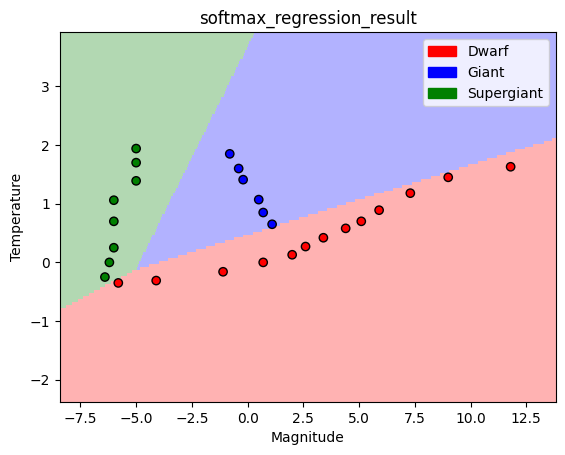

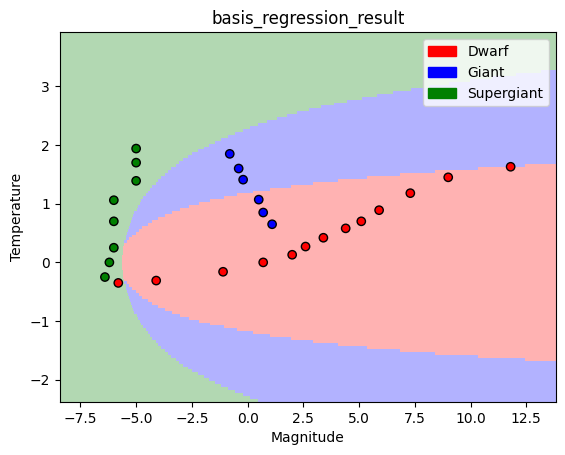

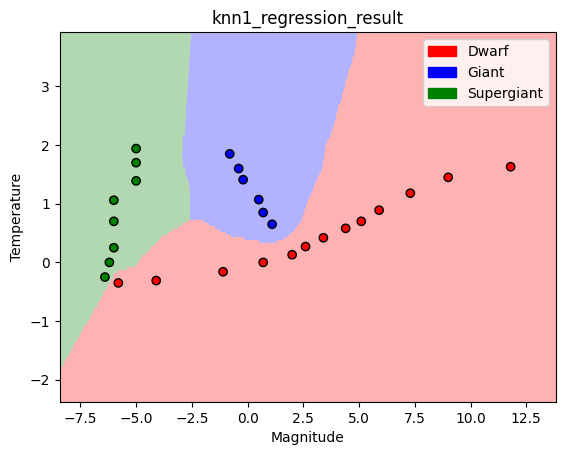

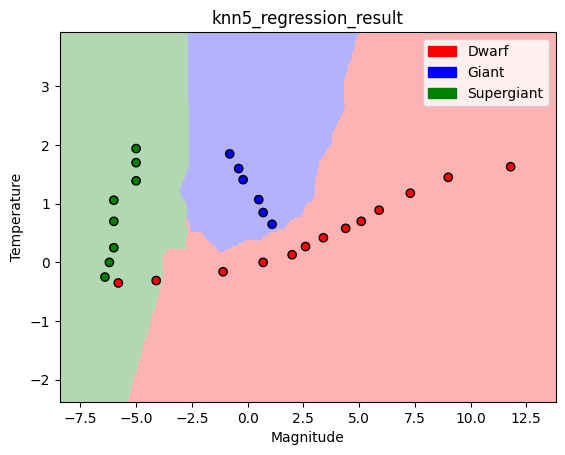

In [20]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
softmax_model = SoftmaxRegression(eta=0.001, lam=0.001)
softmax_model.fit(X_stars, y_stars)
visualize_boundary(model=softmax_model,
                   X=X_stars,
                   y=y_stars,
                   title='softmax_regression_result',
                   basis=None)
                   
basis_model = SoftmaxRegression(eta=0.001, lam=0.001)
basis_model.fit(phi(X_stars), y_stars)
visualize_boundary(model=basis_model,
                   X=X_stars,
                   y=y_stars,
                   title='basis_regression_result',
                   basis=phi)

knn1_model = KNNClassifier(1)
knn1_model.fit(X_stars, y_stars)
visualize_boundary(model=knn1_model,
                   X=X_stars,
                   y=y_stars,
                   title='knn1_regression_result',
                   basis=None)

knn5_model = KNNClassifier(5)
knn5_model.fit(X_stars, y_stars)
visualize_boundary(model=knn5_model,
                   X=X_stars,
                   y=y_stars,
                   title='knn5_regression_result',
                   basis=None)

In [21]:
# test your models by passing your fitted models into the functions below
# softmax_model is an instance of class SoftmaxRegression fitted to data X_stars, y_stars
# basis_model is an instance of class SoftmaxRegression fitted to data phi(X_stars), y_stars
# knn1_model is an instance of class KNNClassifier with parameter k=1
# knn5_model is an instance of class KNNClassifier with parameter k=5
test_p3_softmax(softmax_model, basis_model)
test_p3_knn(knn1_model, knn5_model)

Passed softmax regression tests
Passed KNN tests


In [24]:
print(softmax_model.predict_proba(np.array([[3,-2]])))
print(basis_model.predict_proba(phi(np.array([[3,-2]]))))
print(knn1_model.predict_proba(np.array([[3,-2]])))
print(knn5_model.predict_proba(np.array([[3,-2]])))


[[1.00000000e+00 1.31778926e-28 2.56768493e-40]]
[[0.03425432 0.96455651 0.00118917]]
[[1. 0. 0.]]
[[1. 0. 0.]]
